# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

In [1]:
#@title Cargar librerías
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import operator
import copy

import pickle
import codecs

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


In [2]:
#@title PARÁMETROS

#@markdown Parámetros del Espacio  de búsqueda:

# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

#@markdown Parámetros del Algoritmo PSO:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100 #@param {type:"integer"}

# Cantidad de Particulas
CANT_PARTICULAS = 10 #@param {type:"slider", min:1, max:50, step:1}

# Parámetros de atracción
COEF_ATRACCION_MEJOR_CICLO = 2 #@param {type:"number"}
COEF_ATRACCION_MEJOR_CORRIDA = 3 #@param {type:"number"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos



Clase Mapa de Búqueda definida

> Usando configuración de mapa de búsqueda definida en hash.

> Mapa de búsqueda definido:

** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **



> Hash del mapa de búsqueda definido: 
gASVxQAAAAAAAACMCF9fbWFpbl9flIwMTWFwYUJ1c3F1ZWRhlJOUKYGUfZQojAZsaW1NaW6UShj8
//+MBmxpbU1heJRN6AOMB2NhbnRNYXiUSwOMCk1heGltb3NQb3OUXZQoXZQoS2RLZGVdlChKDP7/
/0oM/v//ZV2UKE1YAk1YAmVdlChKkf///0qR////ZWWMCk1heGltb3NWYWyUXZQoS2RLMks8SvX/
//9ljAtNYXhPcHRpbW9JRJRLAIwBWJROjAFZlE6MAVqUTnViLg==


> Gráfico en 2D del Mapa de Búsqueda:


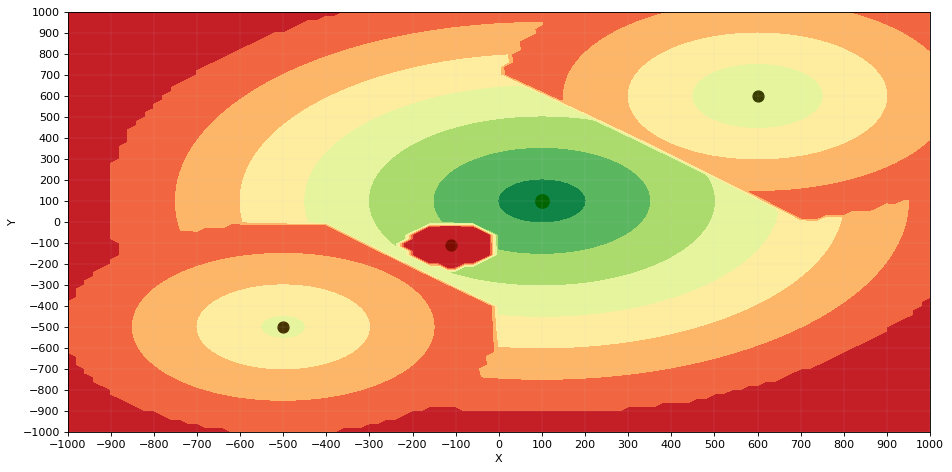

(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)

> Gráfico en 3D del Mapa de Búsqueda:


Output()

In [3]:
#@title clase MAPA DE BÚSQUEDA
Hash_configuracion_Mapa_Busqueda = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChLZEtk ZV1xCShKDP7//0oM/v//ZV1xCihNWAJNWAJlXXELKEqR////SpH///9lZVgKAAAATWF4aW1vc1Zh bHEMXXENKEtkSzJLPEr1////ZVgLAAAATWF4T3B0aW1vSURxDksAWAEAAABYcQ9OWAEAAABZcRBO WAEAAABacRFOdWIu" #@param {type:"string"}

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.X, self.Y, self.Z = None, None, None
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):
            # define al azar
            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
            auxVal = random.randint(-20, 100)
            # asigna
            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            # determina mejor
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i = i + 1
        return True

    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos

    @property
    def valMaximos(self):
        return self.MaximosVal

    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]

    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion, devSinNegativos=True):
        # Define la Función Heurística para evaluar una posicion del mapa
        devHeuristica = None
        minDist = None
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):
              # calcula la distancia a la posicion indicada
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  (math.fsum(sqerrors)**0.5) / 10
              # calcula la heurística correspondiente depende de la distancia
              # y si el valor del máximo es positivo o negativo
              if valMax >= 0:
                auxHeur = max(valMax - distPos, 0)
              else:
                auxHeur = min(valMax + distPos, 0)
              # si tiene heurística definida
              if (auxHeur != 0):
                # determina si es la menor distancia
                # o igual distancia con mayor heurística
                if (minDist is None) or (distPos < minDist) \
                  or ((distPos == minDist) and (devHeuristica < auxHeur)):
                    minDist = distPos
                    devHeuristica = auxHeur
        # Por las dudas controla que este definida y se  un valor positivo
        if devHeuristica is None:
          return 0
        else:
          if devSinNegativos:
            # ajusta la heurística para que no devuelva valores negativos
            # (puede complicar algunos métodos de selección de DEAP)
            return max(devHeuristica, 0)
          else:
            return devHeuristica


    def genDatosGraficos(self):
      if not((self.X is None) or (self.Y is None) or (self.Z is None)):
        # ya está definido, no hace falta re-generarlo
        return
      # define los datos para generar el gráfico
      rSep = (self.limMax-self.limMin)/100
      if rSep < 5:
        rSep = 5
      rX = np.arange(self.limMin, self.limMax+1, rSep)
      rY = np.arange(self.limMin, self.limMax+1, rSep)
      X, Y = np.meshgrid(rX, rY)
      # inicia los valores de aptitud
      Z = np.zeros((X.shape[0], X.shape[1]))
      # completa los valores de aptitud
      for i in range(X.shape[0]):
        for j in range(X.shape[1]):
          Z[i][j] = self.funcHeuristica( [ X[i][j], Y[i][j] ], False )
      #return X, Y, Z
      self.X, self.Y, self.Z = X, Y, Z
      return

    # método que se usa para generar gradiente de colores
    def colorFader(self, c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
        c1 = np.array(mpl.colors.to_rgb(c1))
        c2 = np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    def genGrafico(self, tipoGraph, fig, mostrarEjes=True):
      es3D = (tipoGraph=="3D")
      # generar los datos X, Y, Z
      self.genDatosGraficos()
      # función que genera el gráfico en 3D
      # Genera el tipo de gráfico
      if es3D:
        ax = fig.add_subplot(111, projection='3d')
        # Surface 3D
        surf = ax.plot_surface(self.X, self.Y, self.Z, cmap=cm.RdYlGn,
                              linewidth=1, antialiased=False)
      else:
        ax = fig.add_subplot(111)
        # Superficie colores 2D (contourf)
        plt.contourf(self.X, self.Y, self.Z,  cmap=cm.RdYlGn)
      # muestra las posiciones de los máixmos como Scater
      for posi, vali in zip(self.posMaximos, self.valMaximos):
        valRel = abs(vali / self.valMaximoGlobal)
        c = self.colorFader('darkred', 'darkgreen', valRel)
        if es3D:
          ax.scatter(posi[0], posi[1], vali, color=c, s=100)
        else:
          ax.scatter(posi[0], posi[1], color=c, s=100)
      if es3D:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], self.valMaximoGlobal, color='darkgreen', s=150)
      else:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], color='darkgreen', s=150)
      # define ejes
      if mostrarEjes:
        gTicks = np.arange(self.limMin, self.limMax+1, 100)
        ax.set_xlabel("X")
        plt.xticks(gTicks)
        ax.set_ylabel("Y")
        plt.yticks(gTicks)
      plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.1)
      plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.1)
      if es3D:
        if mostrarEjes:
          ax.set_zlabel("Aptitud")
          #ax.zaxis.set_tick_params(labelsize=18)
        plt.grid(color='lightgrey', which='major', axis='z', linestyle='solid', linewidth=0.1)
      plt.tight_layout()
      return ax

    def graficar2D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 2D del Mapa de Búsqueda:")
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("2D", fig)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def cambiaSeleccionGrafico_3D(self, giroXY=270, elevZ=30):
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("3D", fig)
      # Gira la figura 3D
      ax.view_init(elevZ, giroXY)
      plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = -0.1,
            hspace = 0, wspace = 0)
      ax.margins(0,0,0)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def graficar3D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 3D del Mapa de Búsqueda:")
      # Genera gráfico en 3D del mapa de búsqueda
      style = {'description_width': 'initial'}
      rotXY = IntSlider(description='Giro ejes XY', style=style, min=0, max=360, value=0, step=5)
      rotZ = IntSlider(description='Elevación eje Z', style=style, min=-150, max=150, value=0, step=5)
      ui3D = widgets.HBox([rotXY, rotZ])
      # usar esto para que cambie selección cada vez que se modifica algo
      out3D = widgets.interactive_output(self.cambiaSeleccionGrafico_3D, {'giroXY':rotXY, 'elevZ':rotZ})
      display(ui3D, out3D)


print("\nClase Mapa de Búqueda definida")

# si tiene la configuración definida, la carga sino crea nueva clase
if Hash_configuracion_Mapa_Busqueda != "":
  print("\n> Usando configuración de mapa de búsqueda definida en hash.")
  mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
else:
  # sino define el Mapa de Búsqueda nuevo
  print("\n> Creando nuevo mapa de búsqueda.")
  mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                      cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\n> Mapa de búsqueda definido:")
mapa.printInformacion()
print("\n> Hash del mapa de búsqueda definido: ")
print( codecs.encode(pickle.dumps(mapa), "base64").decode() )

# grafica el mapa de búsqueda
mapa.graficar2D()
mapa.graficar3D()

In [4]:
#@title clase PARTICULA

class Particula(object):

    def __init__(self, mapa):
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)
        self.velocidad = [random.uniform(self.mapa.limMin//10, self.mapa.limMax//10) for _ in range(len(self.pos))]


    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos

    def moverse(self, mejorCiclo, mejorCorrida, coefAtraccMejorCiclo=1.5, coefAtraccMejorCorrida=3):

        for i in range(len(self.pos)):
              # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo y global
            ajusteVel = (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i])) \
                        + (coefAtraccMejorCorrida * random.uniform(0, 1) * (mejorCorrida.posicion[i]-self.pos[i]))
            self.velocidad[i] = self.velocidad[i] + ajusteVel

              # ajusta la posición de la partícula (se ajusta la velocidad para que cambie de a poco)
            self.pos[i] = int(self.pos[i] + self.velocidad[i])

              # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        return copy.deepcopy( self.pos )

print("\nClase Particula definida")


Clase Particula definida


In [5]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True #@param {type:"boolean"}

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")

# vectores auxiliares
ciclo = 1
mejorPartCiclo = None
mejorPartCorrida = None
mejorPartCorrida_ciclo = 0
ciclosParticulas = []
ciclosMaxAptitud = []
partPobla = []

# Define la población de las Particulas
ciclosParticulas.append( [] )
for i in range(CANT_PARTICULAS):
  p = Particula(mapa)
  partPobla.append( p )
  ciclosParticulas[0].append( copy.deepcopy( p.posicion ) )

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorPartCiclo==None) or mejorPartCorrida.heuristica<MIN_HEURISTICA_FINALIZAR):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)

    # Evalúa las particulas de la población para determinar las mejores
    rankingParticulas = sorted(partPobla, key=operator.attrgetter('heuristica'), reverse=True)
    mejorPartCiclo = rankingParticulas[0]
    if mejorPartCorrida == None or mejorPartCiclo.heuristica > mejorPartCorrida.heuristica:
        # congela la particula con la mejor posición encontrada en la corrida
        mejorPartCorrida = copy.deepcopy( mejorPartCiclo )
        mejorPartCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( rankingParticulas[0].heuristica )

    if MUESTRA_DETALLE:
        print(" Mejor Partícula Ciclo:", mejorPartCiclo.posicion, " { ", mejorPartCiclo.heuristica, " } ")
        print(" Mejor Partícula Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ")

    # Actualiza la posición de las partículas
    ciclosParticulas.append( [] )
    for p in partPobla:
        nuevaPos = p.moverse( mejorPartCiclo, mejorPartCorrida, COEF_ATRACCION_MEJOR_CICLO, COEF_ATRACCION_MEJOR_CORRIDA )
        ciclosParticulas[ciclo].append( nuevaPos )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Partícula de la Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ==")


** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **


-- Mínima heurística para finalizar la Corrida:  99 --

-- Ciclo  1 --
 Mejor Partícula Ciclo: [280, 553]  {  27.66  } 
 Mejor Partícula Corrida: [280, 553]  {  27.66  } 

-- Ciclo  2 --
 Mejor Partícula Ciclo: [125, -162]  {  73.68  } 
 Mejor Partícula Corrida: [125, -162]  {  73.68  } 

-- Ciclo  3 --
 Mejor Partícula Ciclo: [11, 600]  {  49.21  } 
 Mejor Partícula Corrida: [125, -162]  {  73.68  } 

-- Ciclo  4 --
 Mejor Partícula Ciclo: [-156, 87]  {  74.37  } 
 Mejor Partícula Corrida: [-156, 87]  {  74.37  } 

-- Ciclo  5 --
 Mejor Partícula Ciclo: [162, -295]  {  60.02  } 
 Mejor Partícula Corrida: [-156, 87]  {  74.37  } 

-- Ciclo  6 --
 Mejor Partícula Ciclo: [-128, 339]  {  66.97  } 
 Mejor Partícula Corrida: [-156, 87]  {  74.37  } 

-- Ciclo  7 --
 Mejor Partícula Ciclo: [572, 539

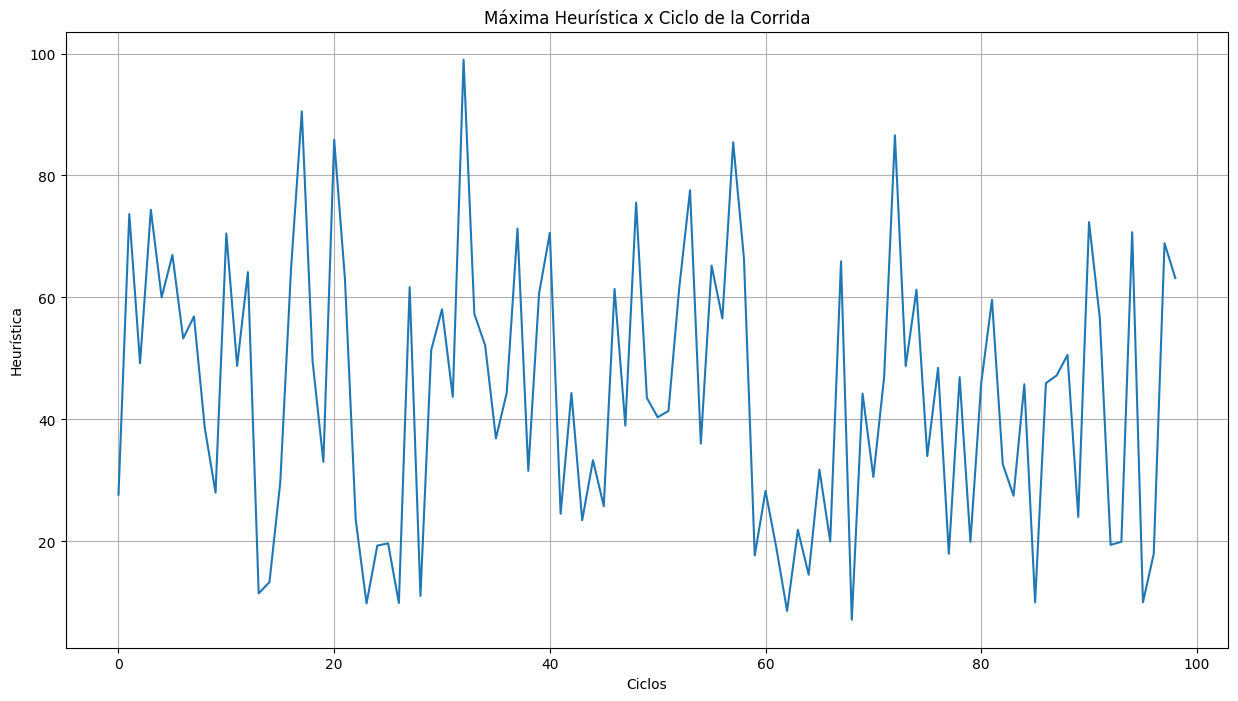

In [6]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.grid(True)
plt.show()

In [7]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LOS INDIVIDUOS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i, ciclosPos, scat, axi, posMejorCorrida, cicloMejorCorrida):
    if axi is None or ciclosPos is None:
      return scat,

    axi.set_xlabel('Ciclo: ' + str(i), fontsize=12)
      # Si no es el último ciclo, muestra también el global
    if i<len(ciclosPos):
      if len(ciclosPos[i])>0:
          if MOSTRAR_HISTORICO_MOVIMIENTO:
              # Coloca nuevas posiciones correspondientes al ciclo
              # Separa las coordenadas x, y de las posiciones en el ciclo i
              X, Y = zip(*ciclosPos[i])
              ## --en Azul: posiciones de las particulas de cada ciclo
              axi.scatter(X, Y, color='blue')
          else:
              # Hace mover a las Partículas
              scat.set_offsets(ciclosPos[i])

    if i>=cicloMejorCorrida:
      if posMejorCorrida is not None:
          ## --en Violeta: Mejor posición de las partículas
          if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
              axi.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
          else:
              X, Y = zip(*posMejorCorrida)
              axi.scatter(X, Y, color='violet', s=100)

    # Devuelve una lista de "artistas" para dibujar,
    # en este caso es sólo uno por lo que se pone una coma final
    return scat,

# Función para preparar el gráfico
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, partMejorCorrida, cicloMejorCorrida, textoTitulo, textoDesc):

    fig = plt.figure(figsize=(12,6), dpi=80)
    #ax = fig.add_subplot(111)
    ax = mapa.genGrafico("2D", fig, False)
    plt.close()

    # Define el tamaño de la figura
    ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

    # Separa las coordenadas x, y de las posiciones en el ciclo inicial
    X, Y = zip(*ciclosPos[0])
    ## --en Azul: posiciones de las posiciones de cada ciclo
    scat = ax.scatter(X, Y, color='blue')

    # Muestra título y texto debajo
    ax.set_title(textoTitulo)
    #ax.set_ylabel(textoDesc, fontsize=11)

    # Luego setea la animación usando los dos métodos anteriores
    cant = len(ciclosPos)+1
    ani = animation.FuncAnimation(fig, updatePlot,
                                  frames=cant, interval=cant,
                                  fargs=(ciclosPos, scat, ax, partMejorCorrida.posicion, cicloMejorCorrida),
                                  blit=True, repeat=False)
    return ani

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de las Partículas de la Corrida ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Partícula: ' + str(mejorPartCorrida) + ' { ' + str(round(mejorPartCorrida.heuristica, 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - '
textoDesc = textoDesc + '\n-- Partículas (AZUL) - Mejor Partícula (VIOLETA) -- '

# Prepara el gráfico
ani = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosParticulas, mejorPartCorrida, mejorPartCorrida_ciclo, textoTitulo, textoDesc)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)
print(textoDesc)

Output hidden; open in https://colab.research.google.com to view.